In [1]:
import sys
sys.path.append('/home/esp/data_analyze/05.02.2025/code')

import pandas as pd
import microbiome_analysis as ma
import microbiome_subgroup_analysis as msa

import warnings
warnings.filterwarnings('ignore')


# Настройка путей и переменных
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'only_family_sub_v2'
GROUP_LIST = ['OB-BPD/DS ', 'CHJ-BPD/DS+', 'CHJ-BPD/DS-', 'CN/SD ']
SUPGROUP_LIST = ['MAM-J', 'MAM-I', 'MAMLI', 'MAM-D', 'Fecal']

DF = pd.read_csv(
    f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/out_data/{PART_OF_PATH}_out.csv',
    sep='\t',
    index_col=[0]
)

PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = True
SHOW = True

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

def filter_taxa_by_prevalence(df, 
                              abundance_col='RelativeAbundance', 
                              sample_col='#SampleID', 
                              taxonomy_col='Taxonomy',
                              presence_threshold=0.01, 
                              min_samples_fraction=0.1):
    n_samples = df[sample_col].nunique()
    presence_counts = (
        df[df[abundance_col] >= presence_threshold]
        .groupby(taxonomy_col)[sample_col]
        .nunique()
    )
    min_count = int(np.ceil(n_samples * min_samples_fraction))
    prevalent_taxa = presence_counts[presence_counts >= min_count].index
    filtered_df = df[df[taxonomy_col].isin(prevalent_taxa)].copy()
    return filtered_df

def remove_outliers_iqr(df, group_col, value_col, factor=1.5):
    filtered_list = []
    outliers_list = []
    
    for g, sub_df in df.groupby(group_col):
        Q1 = sub_df[value_col].quantile(0.25)
        Q3 = sub_df[value_col].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - factor * iqr
        upper = Q3 + factor * iqr
        
        mask = sub_df[value_col].between(lower, upper)
        filtered_list.append(sub_df[mask])
        outliers_list.append(sub_df[~mask])
    
    return pd.concat(filtered_list), pd.concat(outliers_list)

def test_taxa_kruskal_fdr(df, group_col='GROUP', value_col='RelativeAbundance', taxonomy_col='Taxonomy'):
    results = []
    unique_taxa = df[taxonomy_col].unique()

    for taxon in unique_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        grouped_data = [
            df_taxon.loc[df_taxon[group_col] == g, value_col].dropna().values
            for g in df[group_col].unique()
        ]
        if all(len(arr) > 0 for arr in grouped_data):
            stat, p_val = kruskal(*grouped_data)
            results.append((taxon, p_val))

    if len(results) > 0:
        taxa, pvals = zip(*results)
        pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
        results_df = pd.DataFrame({
            taxonomy_col: taxa,
            'p_value_raw': pvals,
            'p_value_fdr': pvals_corrected
        })
        return results_df.sort_values('p_value_fdr')
    else:
        return pd.DataFrame(columns=[taxonomy_col, 'p_value_raw', 'p_value_fdr'])



df_filtered = filter_taxa_by_prevalence(DF, 
                                        presence_threshold=0.01, 
                                        min_samples_fraction=0.1)

df_filtered["Taxonomy"] = "k_" + df_filtered["Taxonomy"]


results_kruskal = test_taxa_kruskal_fdr(df_filtered, 'GROUP', 'RelativeAbundance', 'Taxonomy')
df_filtered.shape

(5586, 7)

In [3]:
def filter_taxa_by_level(df, taxonomy_col='Taxonomy', level='genus'):
    """
    Фильтрует таксоны по заданному уровню (например, genus, family, species).

    Параметры:
    ----------
    df : pd.DataFrame
        DataFrame с колонкой, содержащей таксономию.
    taxonomy_col : str, optional
        Название колонки с таксономией (по умолчанию 'Taxonomy').
    level : str, optional
        Уровень таксономии, который нужно оставить. Допустимые значения:
        'phylum', 'class', 'order', 'family', 'genus', 'species'.
        По умолчанию 'genus'.

    Возвращает:
    -----------
    pd.DataFrame
        DataFrame с отфильтрованными таксонами.
    """
    level_prefixes = {
        'kingdom': 'k_',
        'phylum': 'p_',
        'class': 'c_',
        'order': 'o_',
        'family': 'f_',
        'genus': 'g_',
        'species': 's_'
    }

    if level not in level_prefixes:
        raise ValueError(f"Неподдерживаемый уровень таксономии: {level}. "
                         f"Допустимые значения: {list(level_prefixes.keys())}")

    prefix = level_prefixes[level]

    df_filtered = df.copy()
    
    # Оставляем только нужный уровень
    df_filtered[taxonomy_col] = df_filtered[taxonomy_col].apply(
        lambda x: '|'.join([part for part in x.split('|') if part.startswith(prefix)]) if isinstance(x, str) else x
    )
    
    # Удаляем строки, где после фильтрации `Taxonomy` пуст
    df_filtered = df_filtered[df_filtered[taxonomy_col] != '']

    # Удаление дубликатов (если они возникли после фильтрации)
    df_filtered = df_filtered.drop_duplicates(subset=['#SampleID', taxonomy_col])

    return df_filtered



In [5]:
df_filtered_family = filter_taxa_by_level(df_filtered, taxonomy_col='Taxonomy', level='family')
print(df_filtered_family.shape)
df_filtered_family.head()


(3325, 7)


#SampleID               Taxonomy       GROUP Subgroup  Value  Total  \
3         10A  f_Methanobacteriaceae  OB-BPD/DS     MAM-J      0  92085   
29        10A   f_Corynebacteriaceae  OB-BPD/DS     MAM-J    195  92085   
96        10A       f_Bacteroidaceae  OB-BPD/DS     MAM-J      2  92085   
103       10A       f_Muribaculaceae  OB-BPD/DS     MAM-J      0  92085   
105       10A       f_Prevotellaceae  OB-BPD/DS     MAM-J     26  92085   

     RelativeAbundance  
3             0.000000  
29            0.002118  
96            0.000022  
103           0.000000  
105           0.000282


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
              sum_sq    df        F    PR(>F)
C(GROUP)   0.482372   3.0  0.36721  0.777272
Residual  10.946767  25.0      NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0953  0.9911 -0.8016  0.9923   False
1  CHJ-BPD/DS+       CN/SD    -0.1379  0.9740 -1.0349  0.7591   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2768  0.8699 -1.2738  0.7201   False
3  CHJ-BPD/DS-       CN/SD    -0.2332  0.9112 -1.2061  0.7397   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.3722  0.7727 -1.4379  0.6936   False


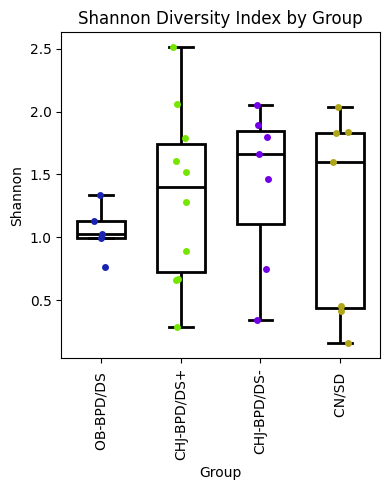


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.068290   3.0  0.316256  0.813476
Residual  1.799428  25.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0611  0.9666 -0.3026  0.4247   False
1  CHJ-BPD/DS+       CN/SD    -0.0678  0.9553 -0.4314  0.2959   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0514  0.9849 -0.4556  0.3528   False
3  CHJ-BPD/DS-       CN/SD    -0.1288  0.8057 -0.5233  0.2656   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1125  0.8897 -0.5446  0.3196   False


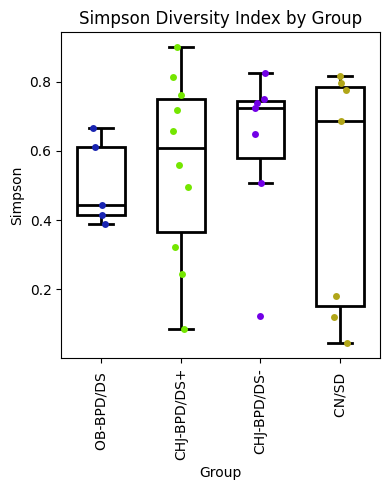


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)   26.855665   3.0  1.690494  0.194556
Residual  132.385714  25.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.9571  0.8330 -4.0765  2.1622   False
1  CHJ-BPD/DS+       CN/SD     0.1857  0.9984 -2.9336  3.3050   False
2  CHJ-BPD/DS+   OB-BPD/DS    -2.5000  0.2209 -5.9669  0.9669   False
3  CHJ-BPD/DS-       CN/SD     1.1429  0.7896 -2.2405  4.5262   False
4  CHJ-BPD/DS-   OB-BPD/DS    -1.5429  0.6658 -5.2492  2.1635   False


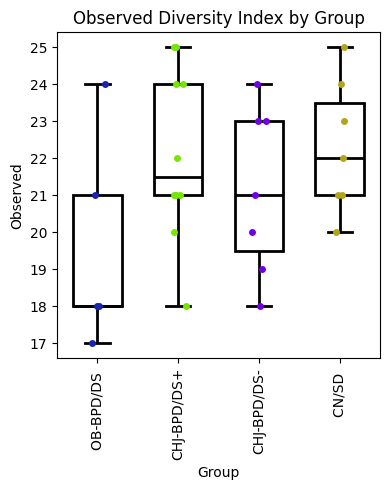


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.044261   3.0  0.328426  0.804807
Residual  1.123064  25.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0380  0.9831 -0.2493  0.3253   False
1  CHJ-BPD/DS+       CN/SD    -0.0414  0.9784 -0.3287  0.2459   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0742  0.9184 -0.3935  0.2452   False
3  CHJ-BPD/DS-       CN/SD    -0.0794  0.8956 -0.3911  0.2322   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1122  0.8028 -0.4536  0.2292   False


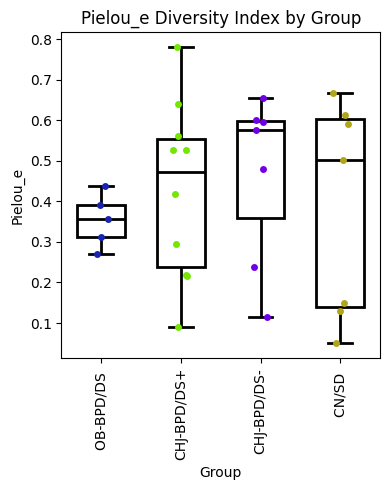

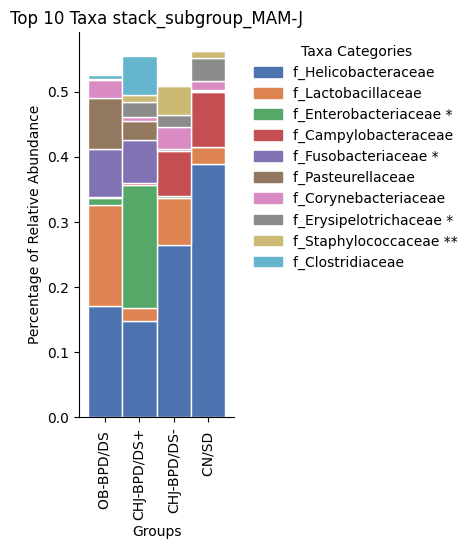

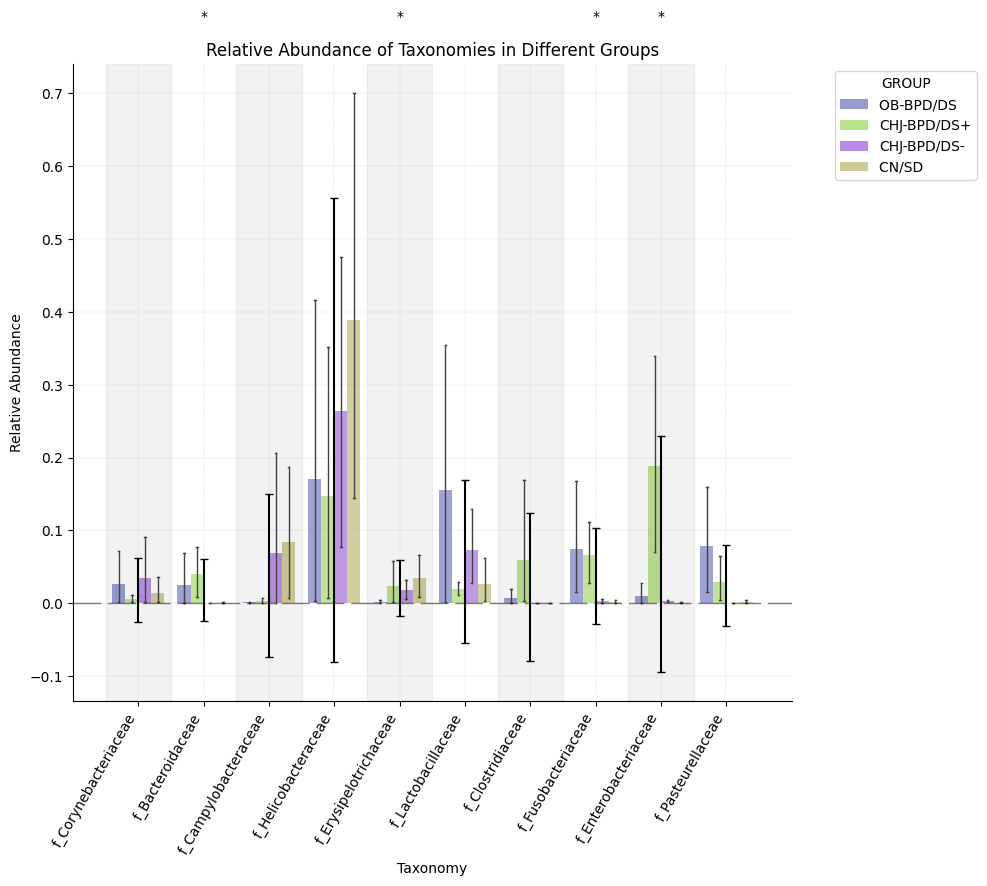

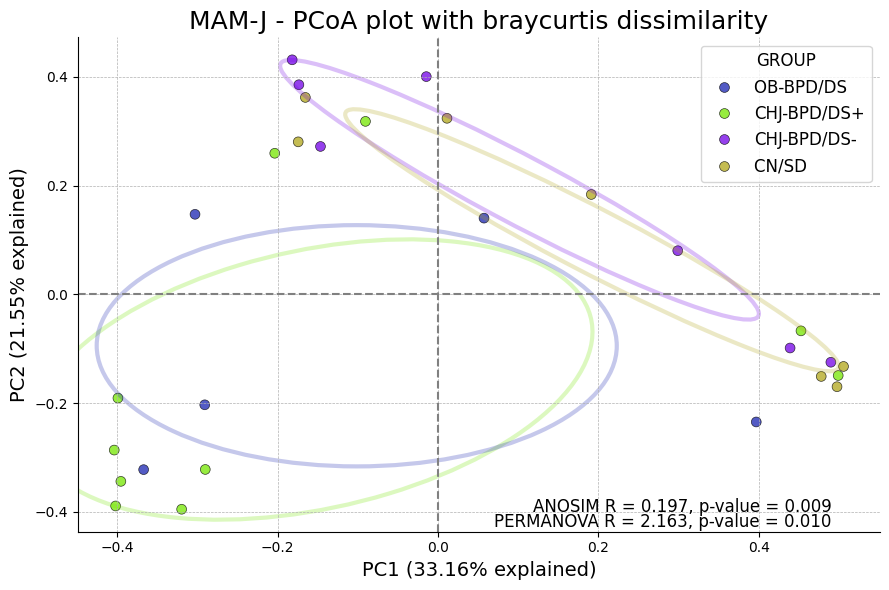

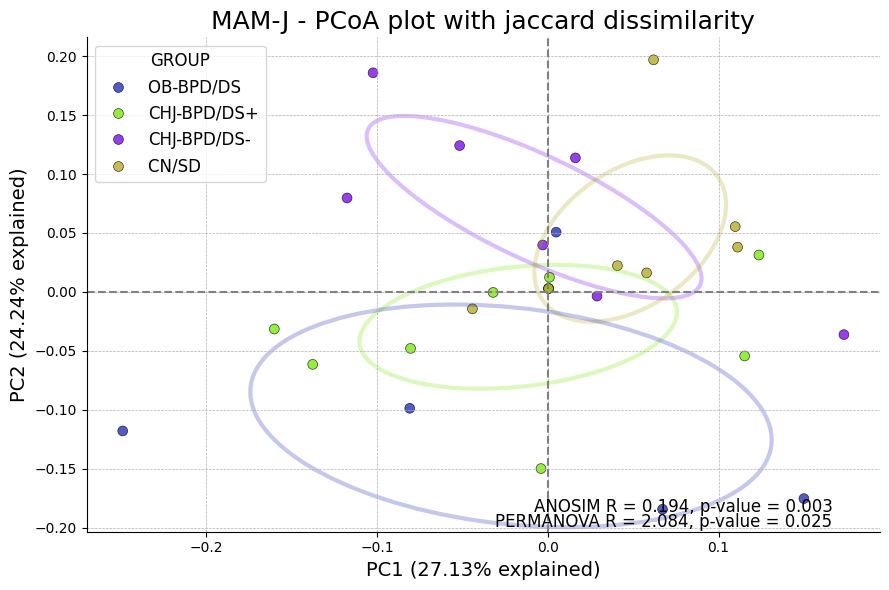

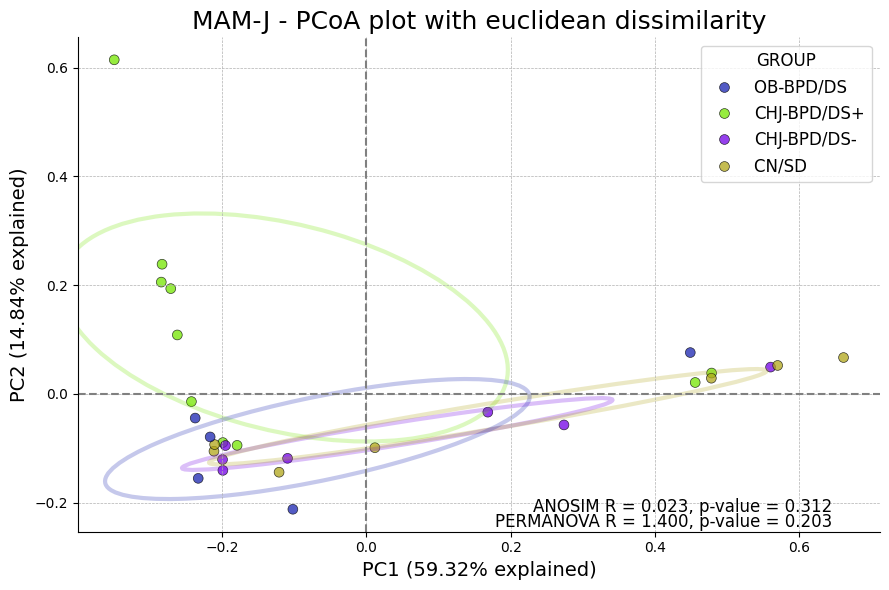

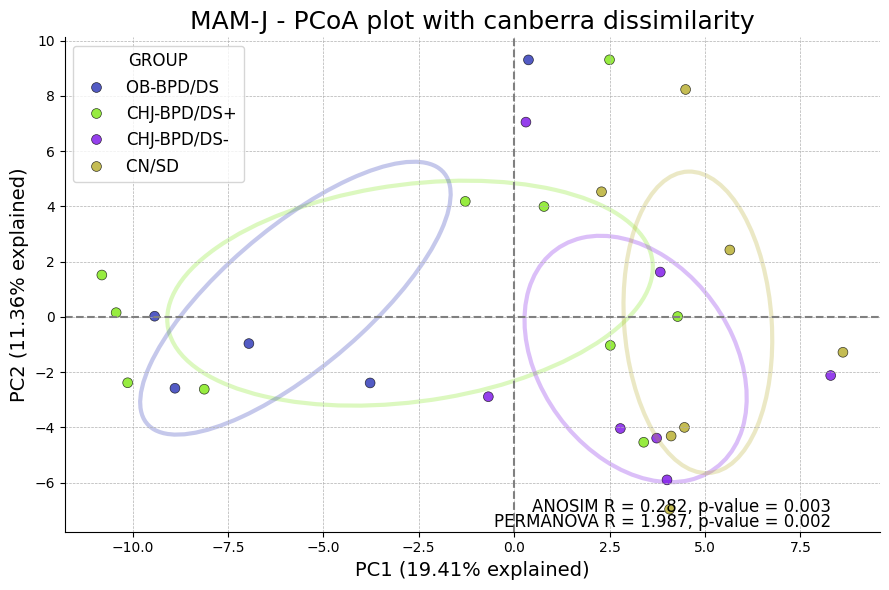

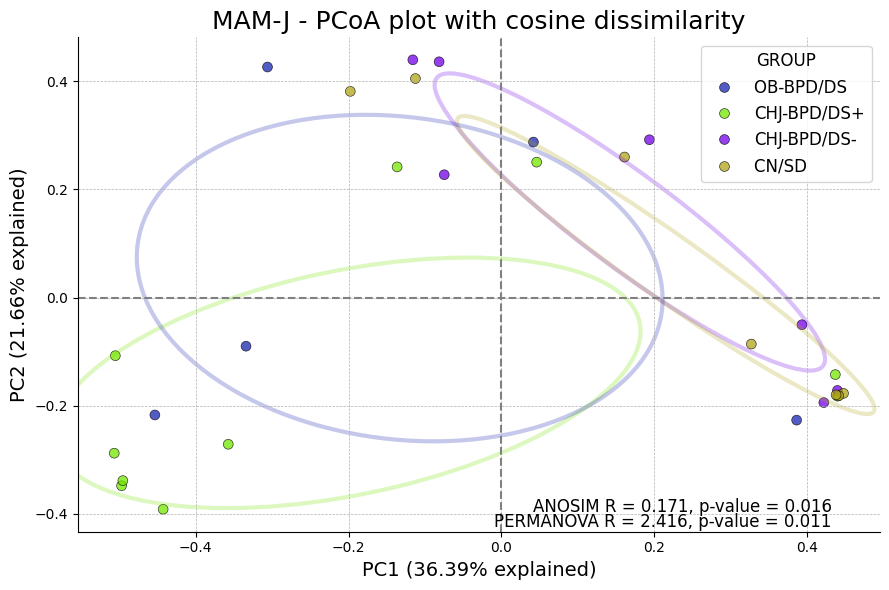


=== Analyzing Subgroup: MAM-I ===

=== SHANNON ANOVA ===
             sum_sq    df        F    PR(>F)
C(GROUP)  0.786095   3.0  0.67126  0.578368
Residual  8.978236  23.0      NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.3003  0.7764 -1.1717  0.5710   False
1  CHJ-BPD/DS+       CN/SD     0.1382  0.9746 -0.7731  1.0494   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2250  0.9160 -1.1894  0.7394   False
3  CHJ-BPD/DS-       CN/SD     0.4385  0.5955 -0.5234  1.4004   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0754  0.9968 -0.9370  1.0877   False


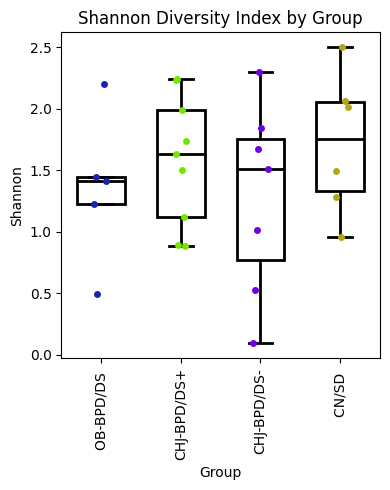


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.108793   3.0  0.719915  0.550292
Residual  1.158586  23.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1107  0.7629 -0.4237  0.2023   False
1  CHJ-BPD/DS+       CN/SD     0.0673  0.9403 -0.2601  0.3946   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0398  0.9886 -0.3863  0.3066   False
3  CHJ-BPD/DS-       CN/SD     0.1780  0.4971 -0.1676  0.5235   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0708  0.9485 -0.2928  0.4345   False


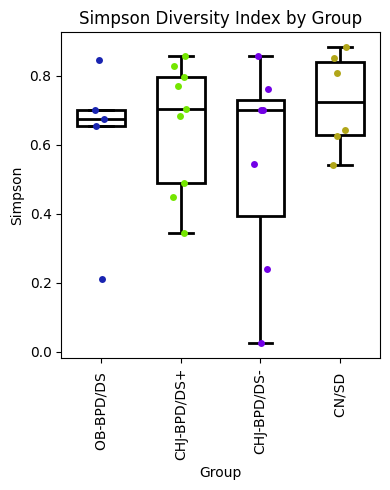


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)   37.274074   3.0  2.249747  0.109597
Residual  127.022222  23.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -1.4444  0.6211 -4.7218  1.8329   False
1  CHJ-BPD/DS+       CN/SD    -0.4444  0.9838 -3.8720  2.9831   False
2  CHJ-BPD/DS+   OB-BPD/DS    -3.2444  0.0909 -6.8718  0.3829   False
3  CHJ-BPD/DS-       CN/SD     1.0000  0.8694 -2.6181  4.6181   False
4  CHJ-BPD/DS-   OB-BPD/DS    -1.8000  0.5673 -5.6079  2.0079   False


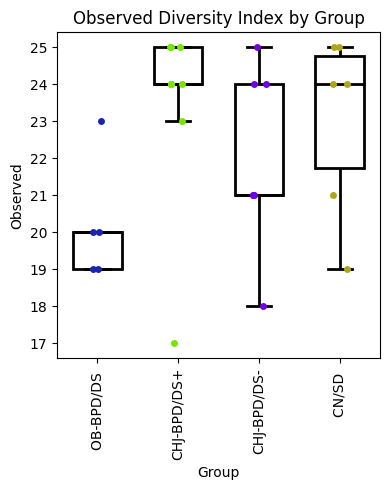


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.071328   3.0  0.609151  0.615852
Residual  0.897725  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0900  0.8030 -0.3655  0.1855   False
1  CHJ-BPD/DS+       CN/SD     0.0501  0.9624 -0.2380  0.3383   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0482  0.9714 -0.3531  0.2568   False
3  CHJ-BPD/DS-       CN/SD     0.1401  0.5875 -0.1640  0.4443   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0418  0.9834 -0.2783  0.3619   False


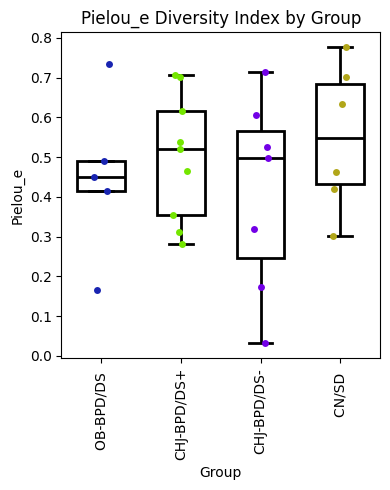

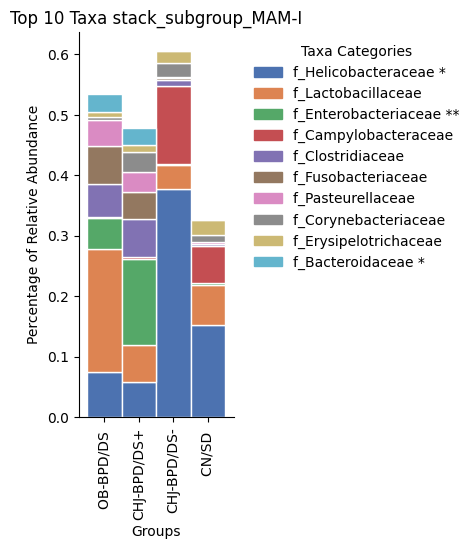

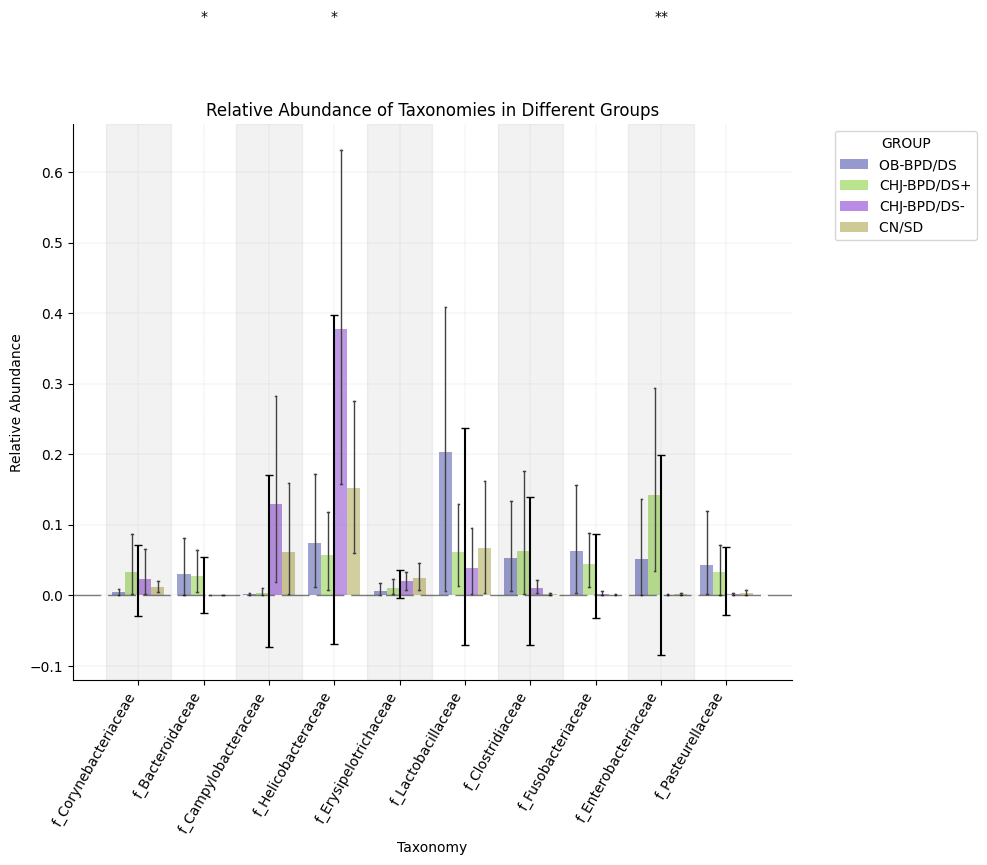

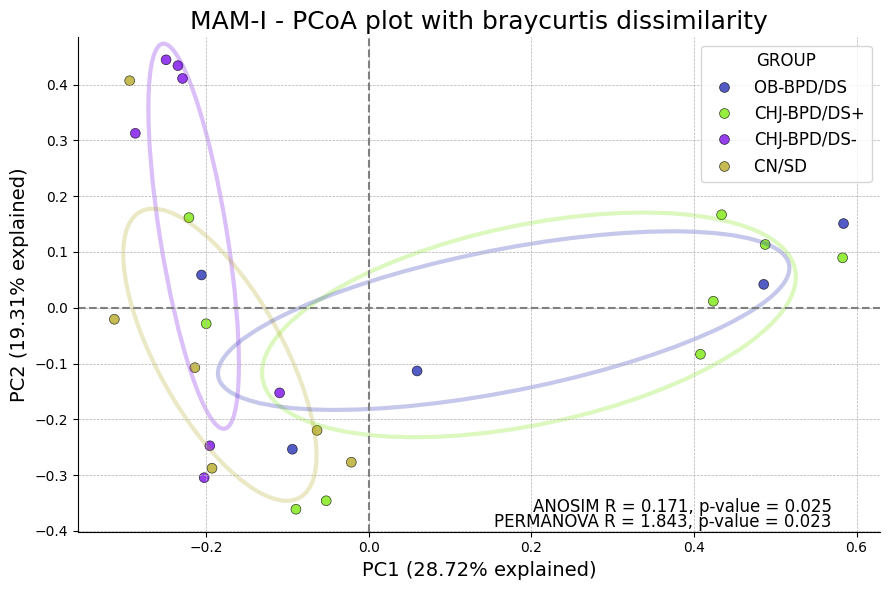

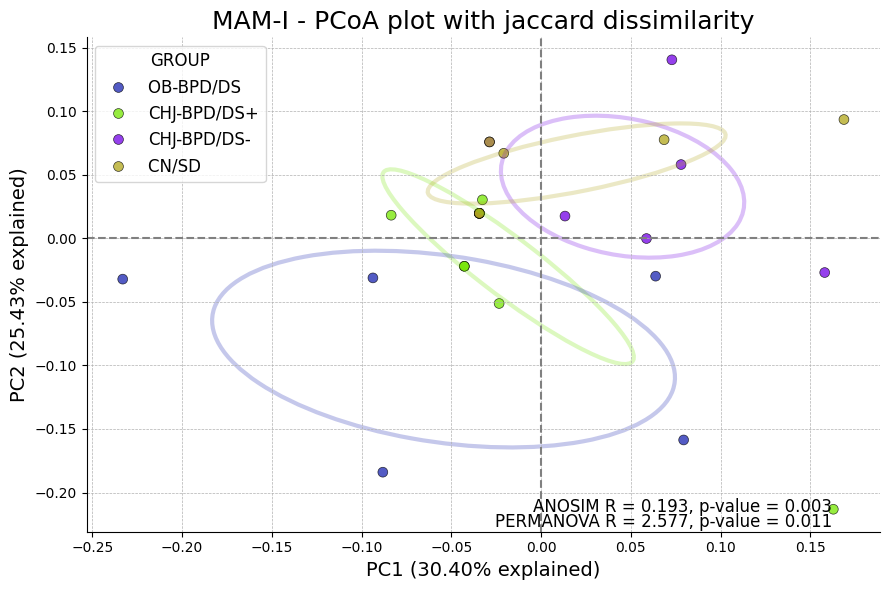

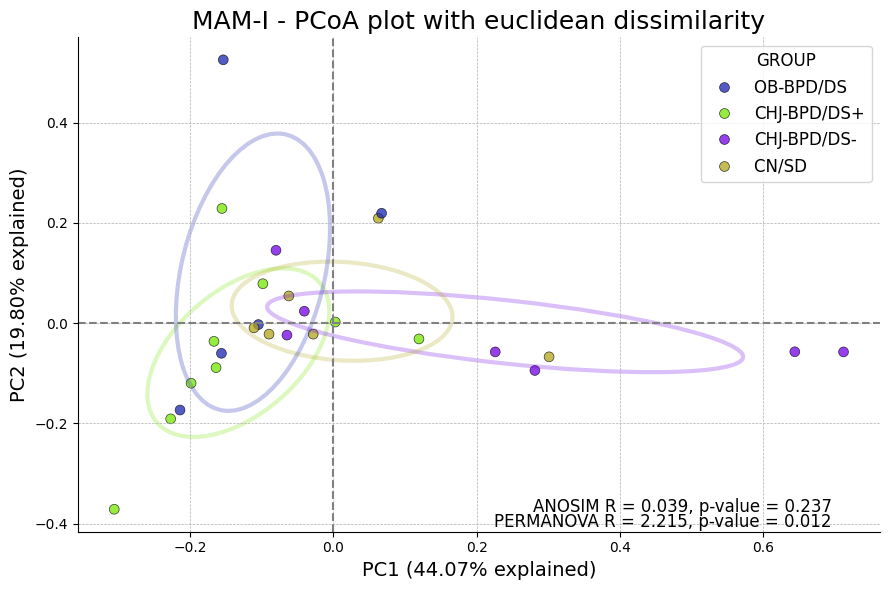

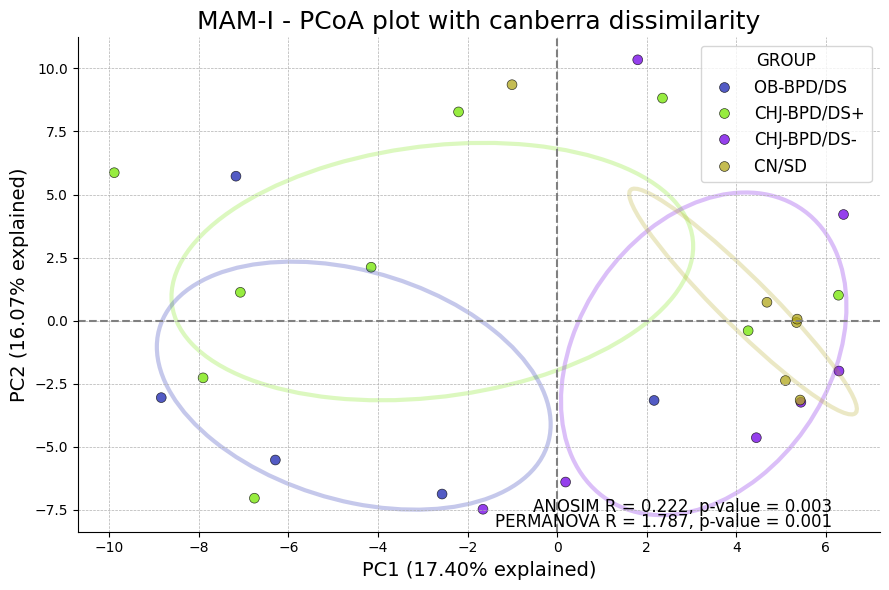

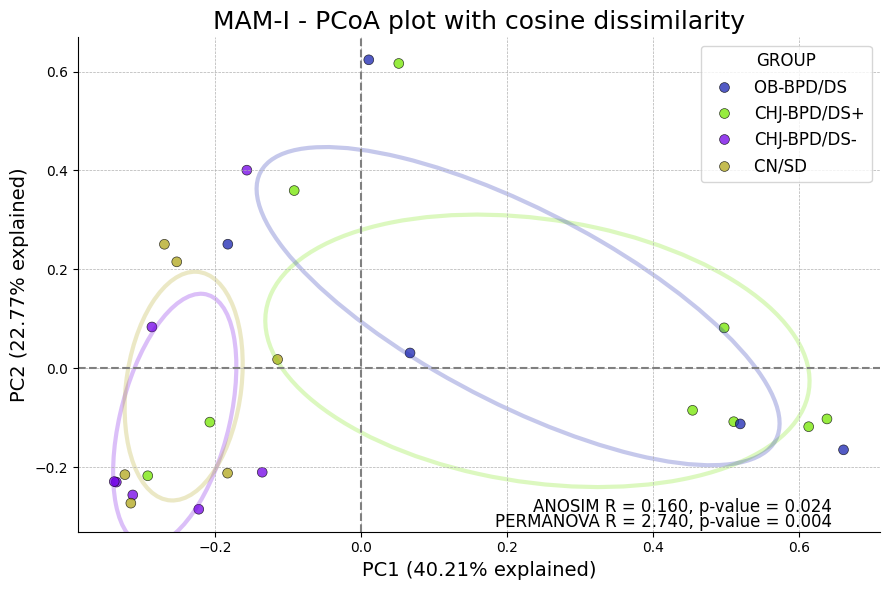


=== Analyzing Subgroup: MAMLI ===

=== SHANNON ANOVA ===
              sum_sq    df         F   PR(>F)
C(GROUP)   1.296671   3.0  0.711803  0.55449
Residual  14.573375  24.0       NaN      NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4590  0.6686 -1.5691  0.6510   False
1  CHJ-BPD/DS+       CN/SD    -0.4914  0.5842 -1.5507  0.5680   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.3190  0.8769 -1.4964  0.8584   False
3  CHJ-BPD/DS-       CN/SD    -0.0324  0.9998 -1.2283  1.1636   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1400  0.9907 -1.1616  1.4417   False


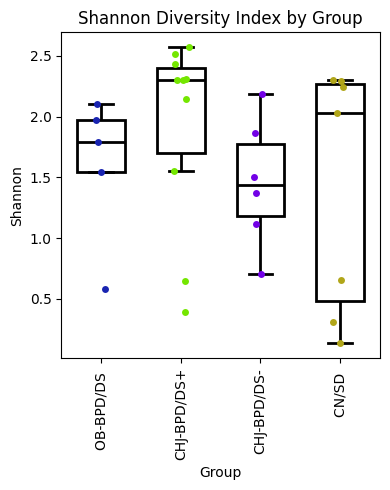


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.159364   3.0  0.641266  0.595925
Residual  1.988118  24.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1434  0.7705 -0.5534  0.2666   False
1  CHJ-BPD/DS+       CN/SD    -0.1787  0.5961 -0.5700  0.2125   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0529  0.9867 -0.4877  0.3820   False
3  CHJ-BPD/DS-       CN/SD    -0.0354  0.9961 -0.4771  0.4064   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0905  0.9536 -0.3903  0.5713   False


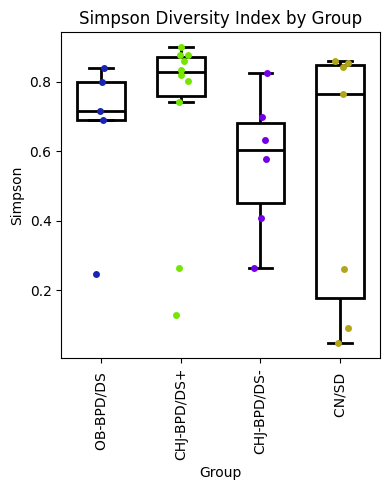


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)   34.652381   3.0  2.613748  0.074471
Residual  106.061905  24.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.9667  0.8098 -2.0280  3.9613   False
1  CHJ-BPD/DS+       CN/SD     1.0143  0.7625 -1.8436  3.8721   False
2  CHJ-BPD/DS+   OB-BPD/DS    -2.1000  0.2871 -5.2763  1.0763   False
3  CHJ-BPD/DS-       CN/SD     0.0476  1.0000 -3.1787  3.2740   False
4  CHJ-BPD/DS-   OB-BPD/DS    -3.0667  0.1023 -6.5782  0.4449   False


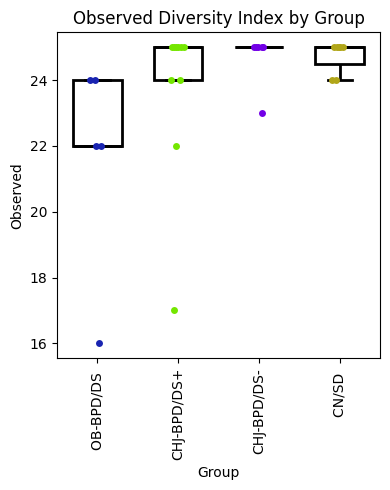


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.128259   3.0  0.742088  0.537435
Residual  1.382681  24.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1447  0.6523 -0.4867  0.1972   False
1  CHJ-BPD/DS+       CN/SD    -0.1553  0.5639 -0.4816  0.1710   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0848  0.9164 -0.4474  0.2779   False
3  CHJ-BPD/DS-       CN/SD    -0.0106  0.9998 -0.3789  0.3578   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0600  0.9758 -0.3410  0.4609   False


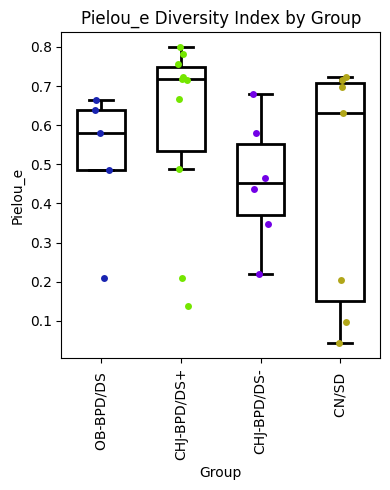

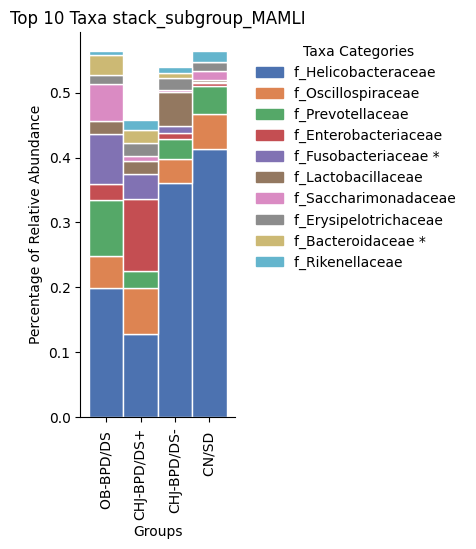

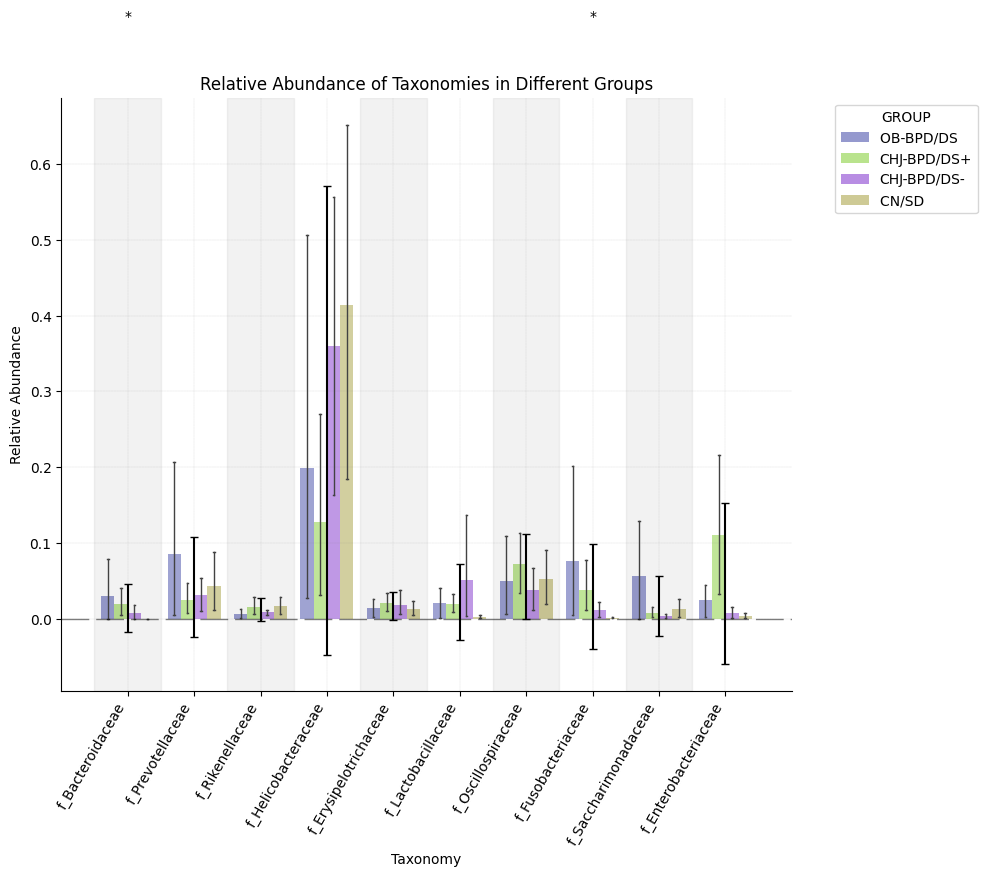

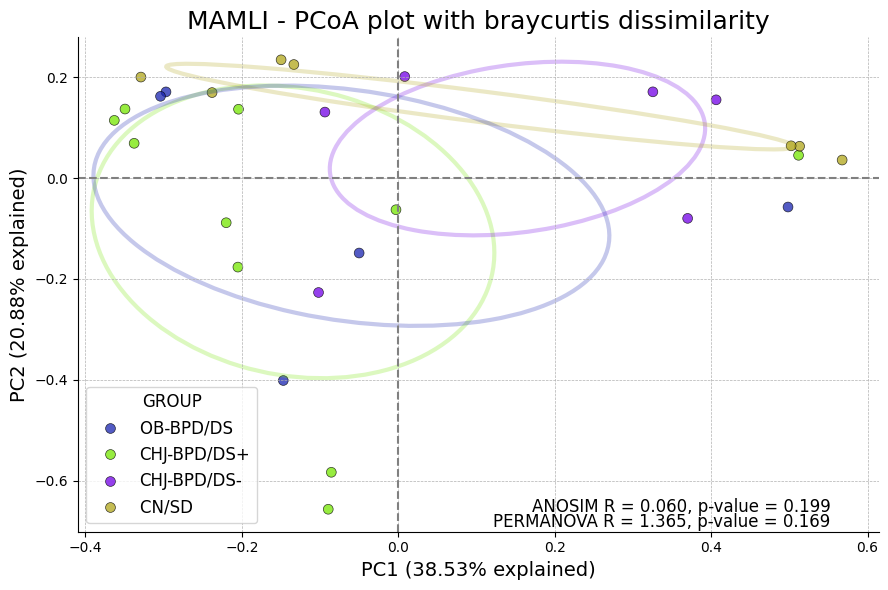

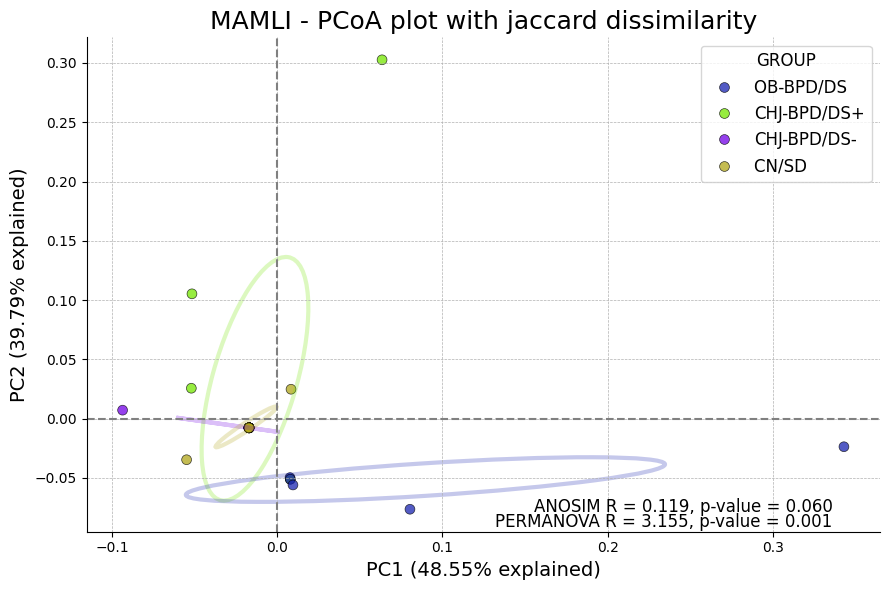

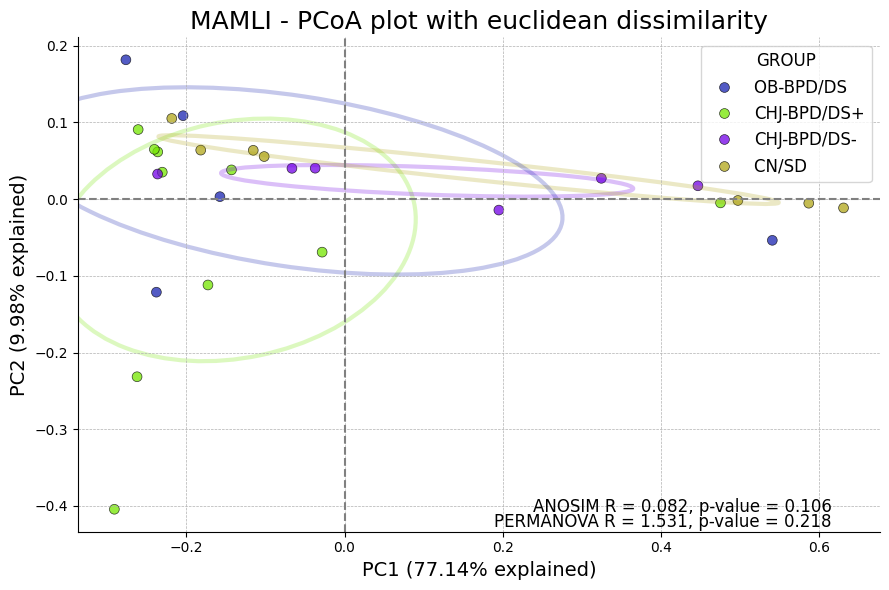

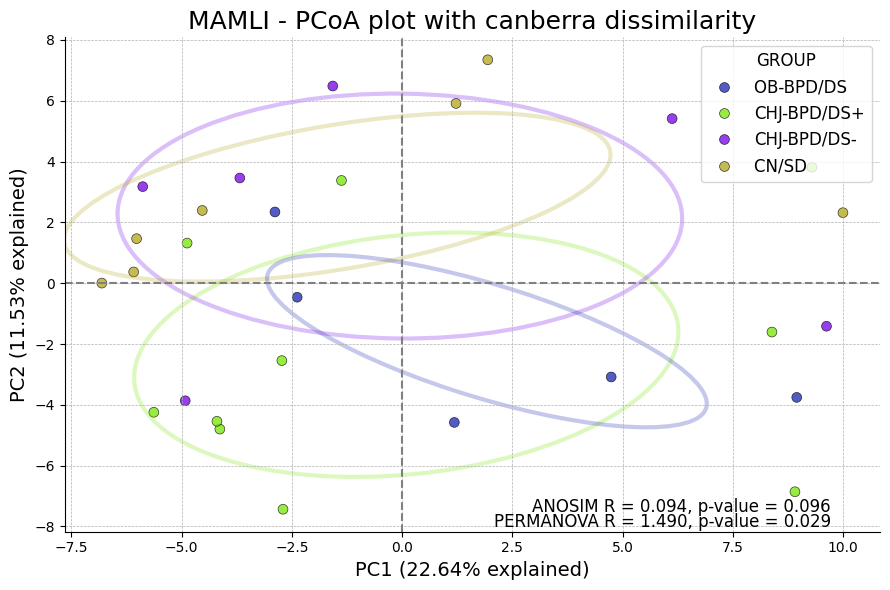

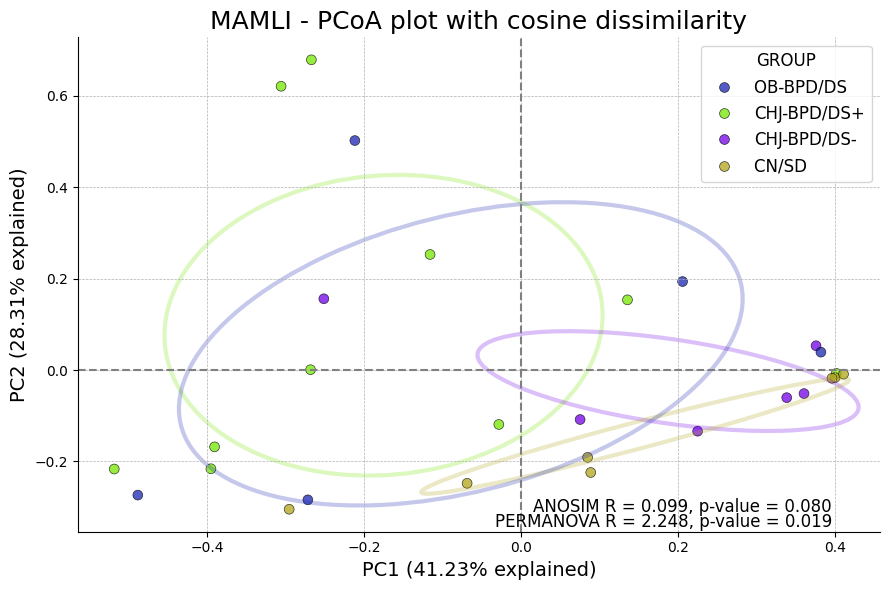


=== Analyzing Subgroup: MAM-D ===

=== SHANNON ANOVA ===
              sum_sq    df        F    PR(>F)
C(GROUP)   2.377185   3.0  1.81849  0.171935
Residual  10.022097  23.0      NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.6360  0.2862 -1.5988  0.3267   False
1  CHJ-BPD/DS+       CN/SD    -0.0156  1.0000 -0.9361  0.9050   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.5774  0.4155 -1.5963  0.4415   False
3  CHJ-BPD/DS-       CN/SD     0.6205  0.3517 -0.3958  1.6368   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0586  0.9988 -1.0475  1.1648   False


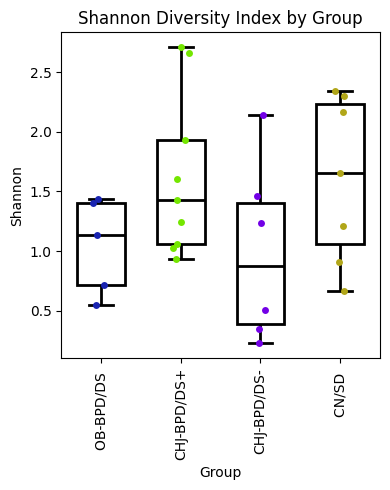


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.277331   3.0  1.423775  0.261431
Residual  1.493358  23.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2585  0.2457 -0.6301  0.1132   False
1  CHJ-BPD/DS+       CN/SD    -0.0546  0.9735 -0.4100  0.3007   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1669  0.6485 -0.5602  0.2264   False
3  CHJ-BPD/DS-       CN/SD     0.2039  0.4896 -0.1885  0.5962   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0916  0.9331 -0.3354  0.5185   False


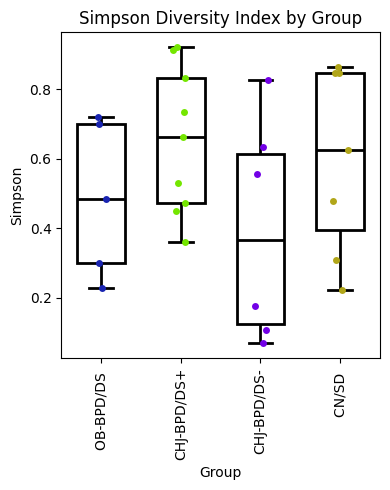


=== OBSERVED ANOVA ===
               sum_sq    df         F    PR(>F)
C(GROUP)  130.739153   3.0  6.721986  0.002022
Residual  149.112698  23.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -3.2778  0.0969 -6.9914  0.4359   False
1  CHJ-BPD/DS+       CN/SD     0.0794  0.9999 -3.4715  3.6303   False
2  CHJ-BPD/DS+   OB-BPD/DS    -5.3778  0.0049 -9.3079 -1.4476    True
3  CHJ-BPD/DS-       CN/SD     3.3571  0.1115 -0.5630  7.2772   False
4  CHJ-BPD/DS-   OB-BPD/DS    -2.1000  0.5347 -6.3666  2.1666   False


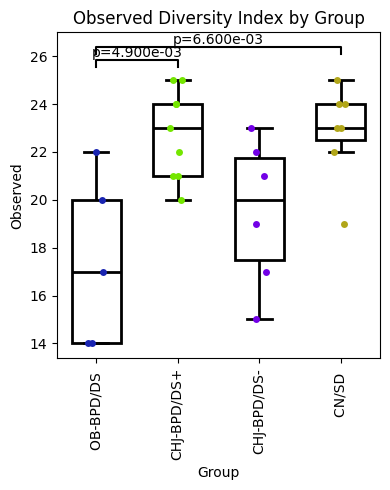


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.191851   3.0  1.380711  0.273722
Residual  1.065287  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1893  0.3624 -0.5031  0.1246   False
1  CHJ-BPD/DS+       CN/SD    -0.0063  0.9999 -0.3064  0.2938   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1526  0.5897 -0.4848  0.1796   False
3  CHJ-BPD/DS-       CN/SD     0.1830  0.4378 -0.1484  0.5143   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0367  0.9920 -0.3240  0.3973   False


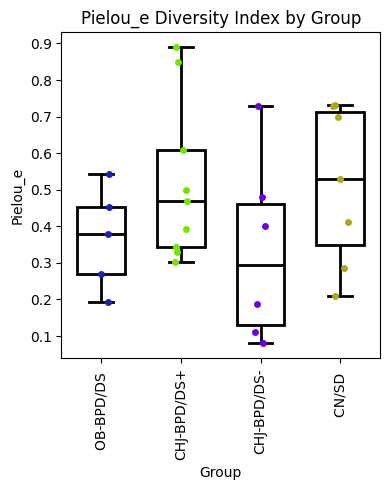

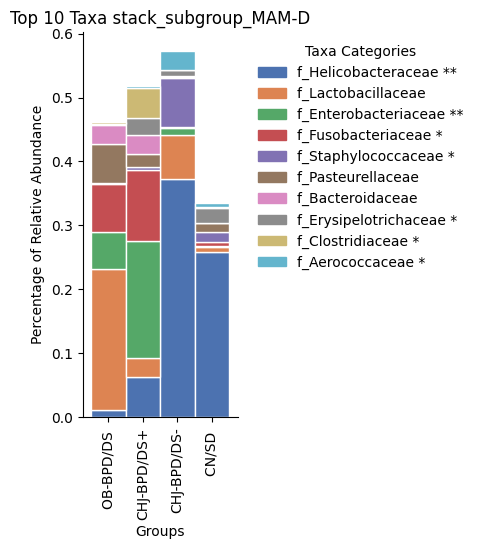

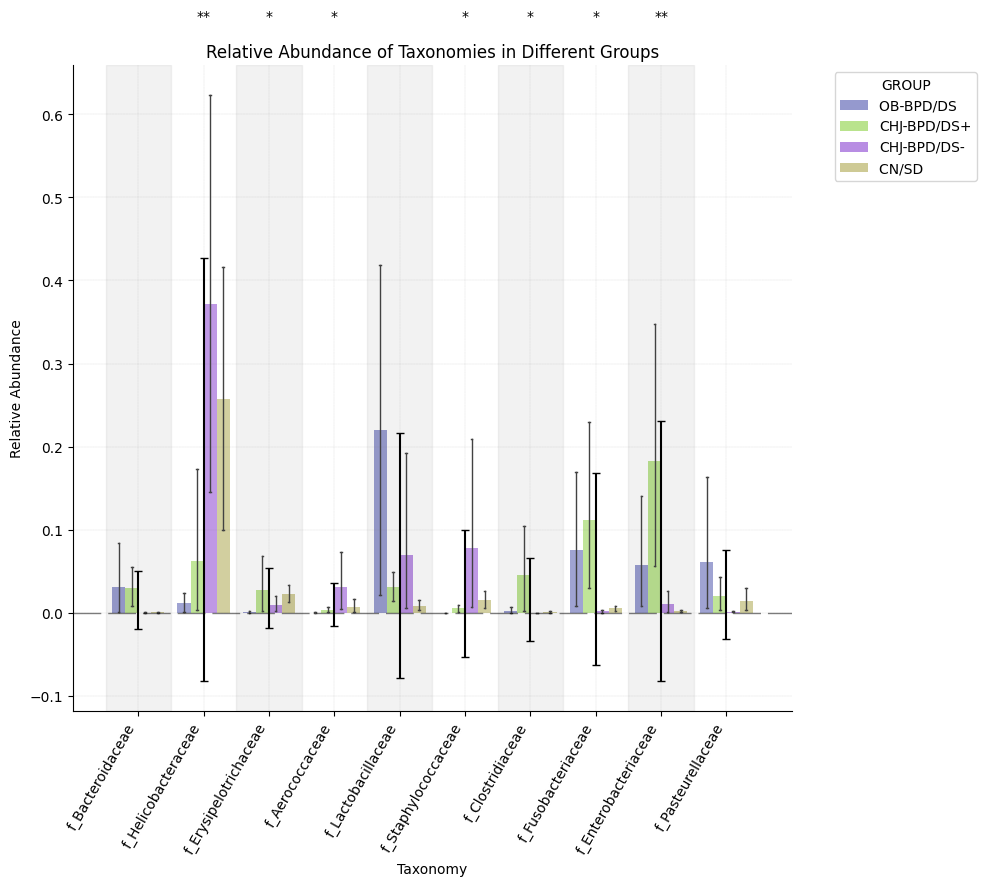

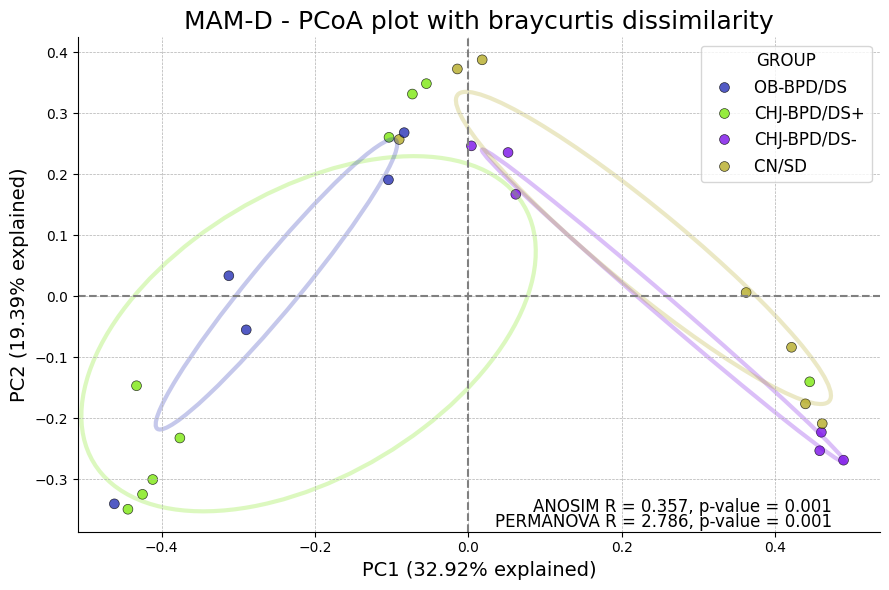

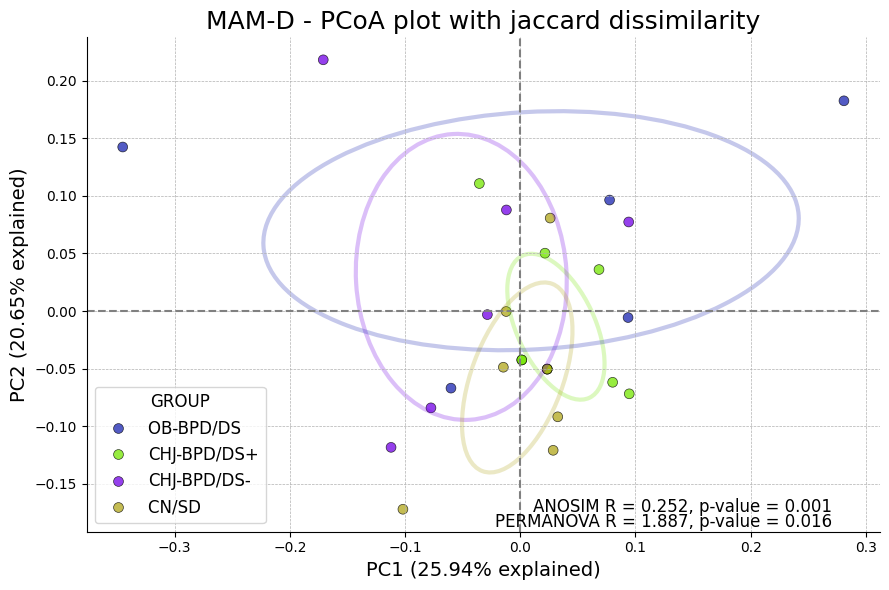

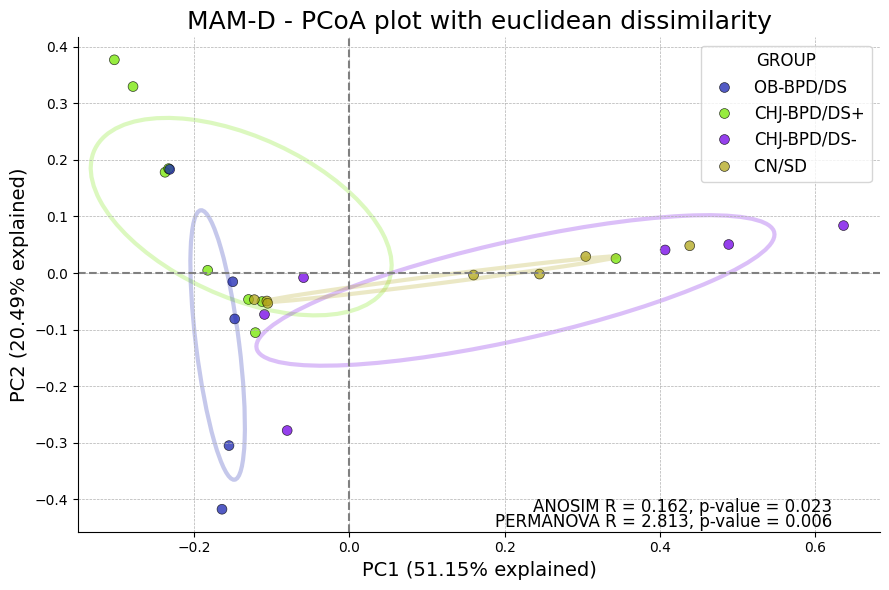

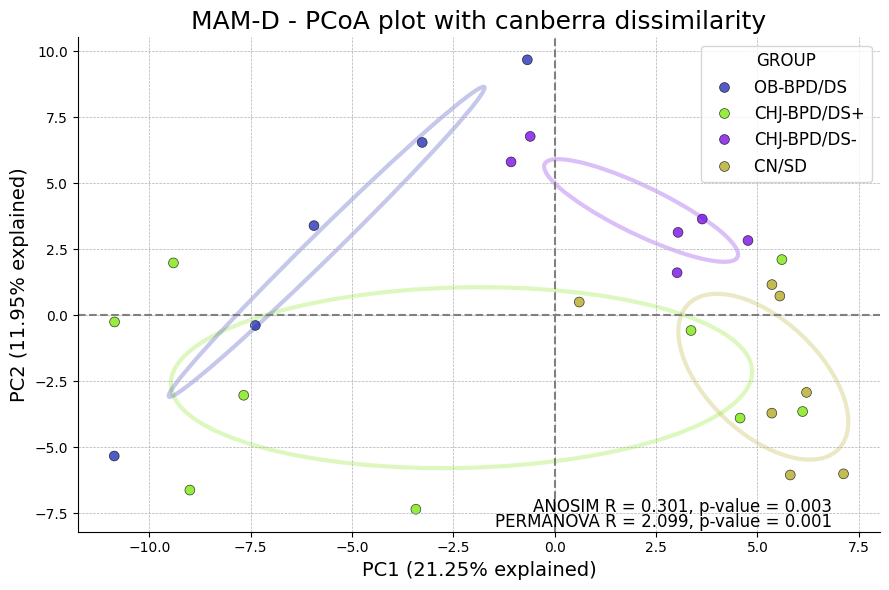

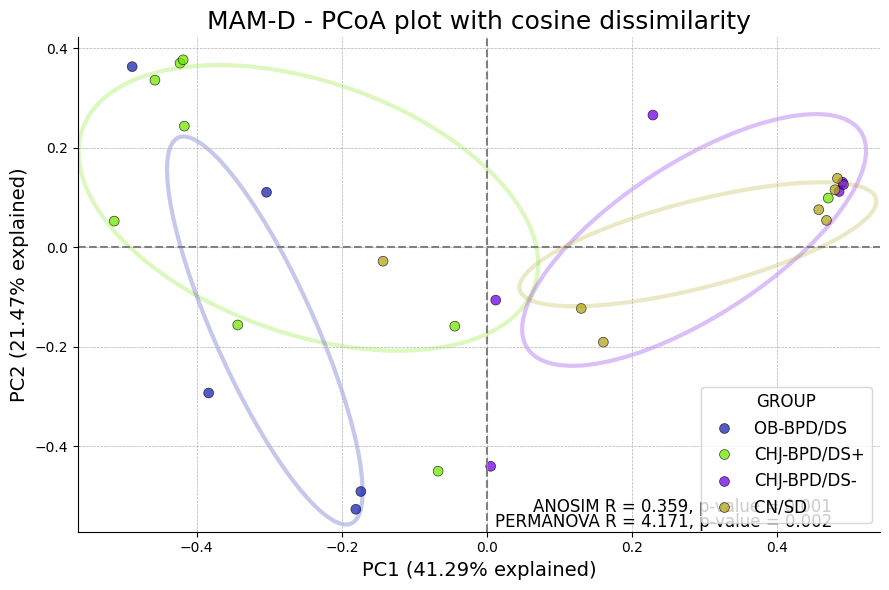


=== Analyzing Subgroup: Fecal ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.576134   3.0  1.797153  0.183803
Residual  1.923487  18.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.1075  0.9279 -0.3915  0.6065   False
1  CHJ-BPD/DS+       CN/SD    -0.0311  0.9986 -0.5969  0.5347   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.3689  0.2866 -0.9347  0.1969   False
3  CHJ-BPD/DS-       CN/SD    -0.1386  0.9118 -0.7350  0.4578   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.4764  0.1456 -1.0728  0.1200   False


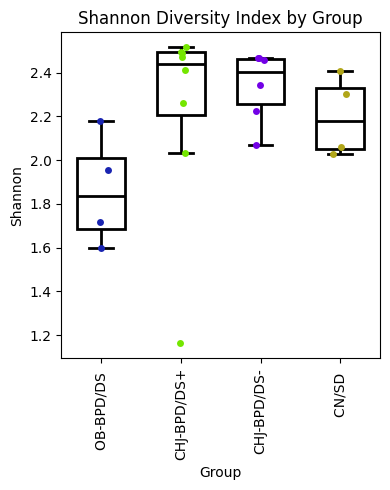


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.037913   3.0  1.780966  0.186819
Residual  0.127728  18.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0282  0.9243 -0.1004  0.1568   False
1  CHJ-BPD/DS+       CN/SD    -0.0041  0.9998 -0.1499  0.1417   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0940  0.2957 -0.2398  0.0518   False
3  CHJ-BPD/DS-       CN/SD    -0.0323  0.9324 -0.1860  0.1214   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1222  0.1483 -0.2759  0.0315   False


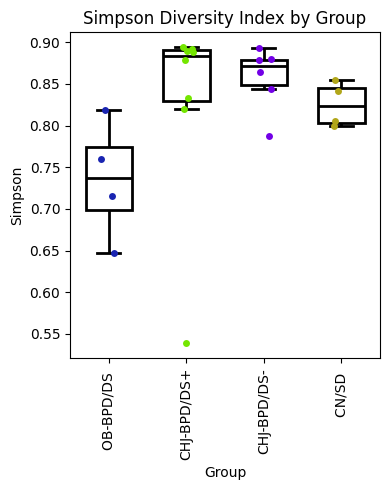


=== OBSERVED ANOVA ===
              sum_sq    df         F   PR(>F)
C(GROUP)   0.984848   3.0  0.479115  0.70082
Residual  12.333333  18.0       NaN      NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.3333  0.8773 -0.9301  1.5968   False
1  CHJ-BPD/DS+       CN/SD     0.2500  0.9596 -1.1826  1.6826   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.2500  0.9596 -1.6826  1.1826   False
3  CHJ-BPD/DS-       CN/SD    -0.0833  0.9986 -1.5935  1.4268   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.5833  0.6989 -2.0935  0.9268   False


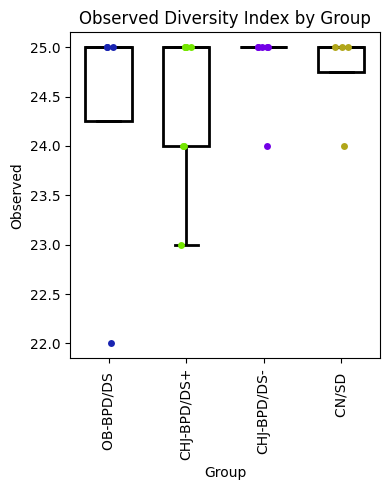


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.052910   3.0  1.784136  0.186225
Residual  0.177934  18.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-    0.0316  0.9342 -0.1201  0.1834   False
1  CHJ-BPD/DS+       CN/SD    -0.0111  0.9978 -0.1831  0.1610   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1125  0.2844 -0.2846  0.0596   False
3  CHJ-BPD/DS-       CN/SD    -0.0427  0.9089 -0.2241  0.1387   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1441  0.1487 -0.3255  0.0373   False


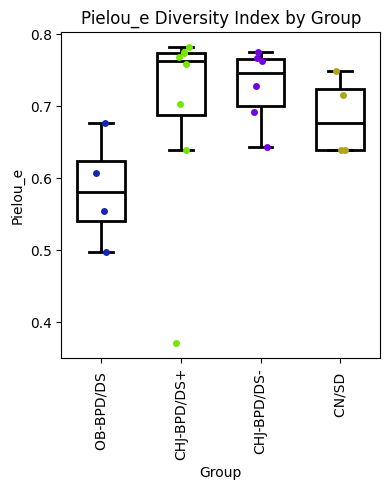

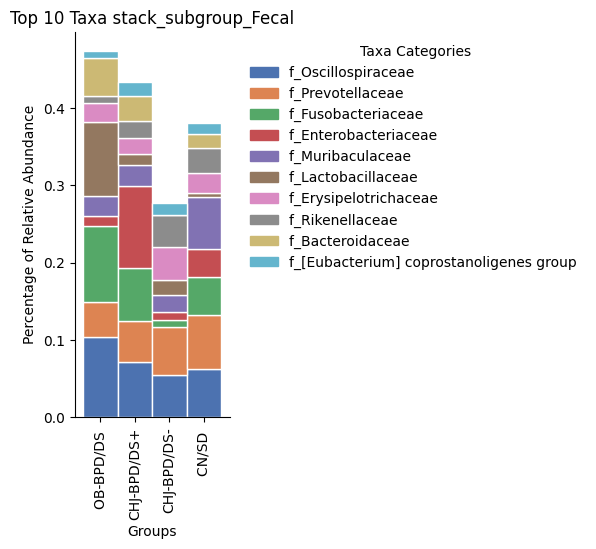

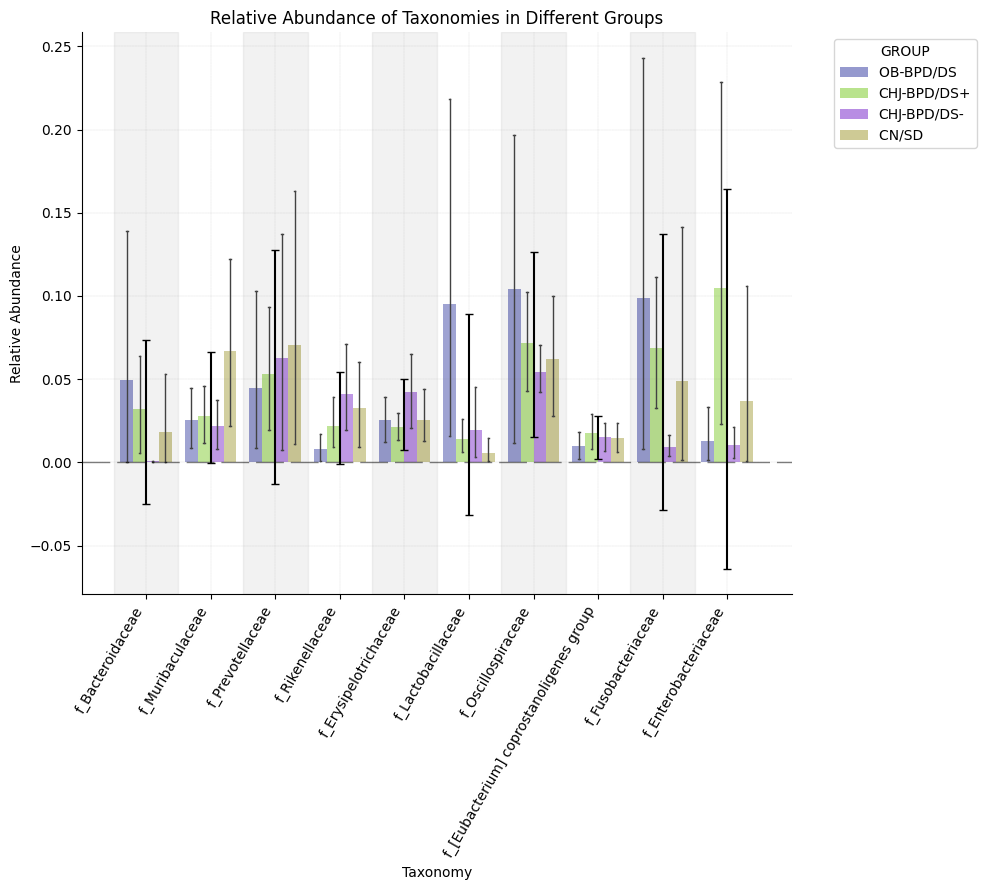

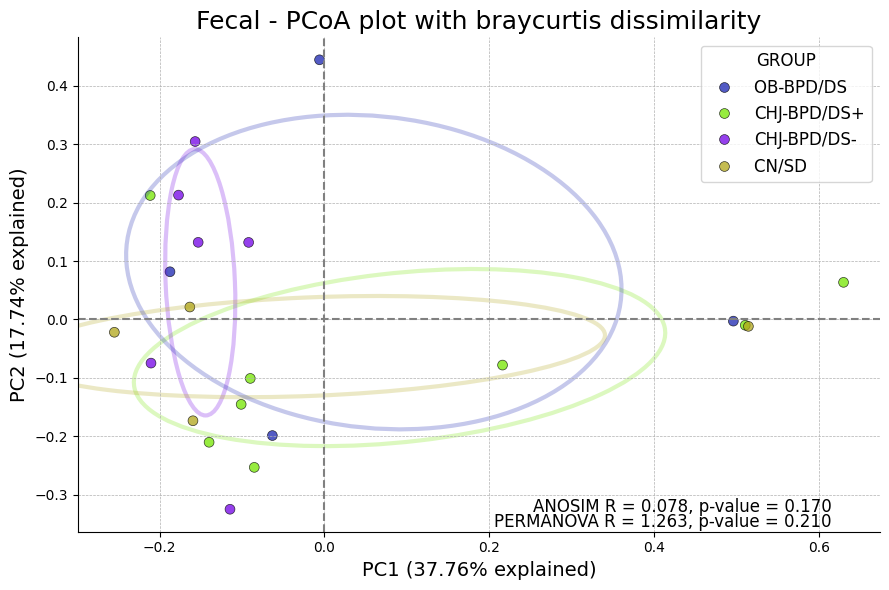

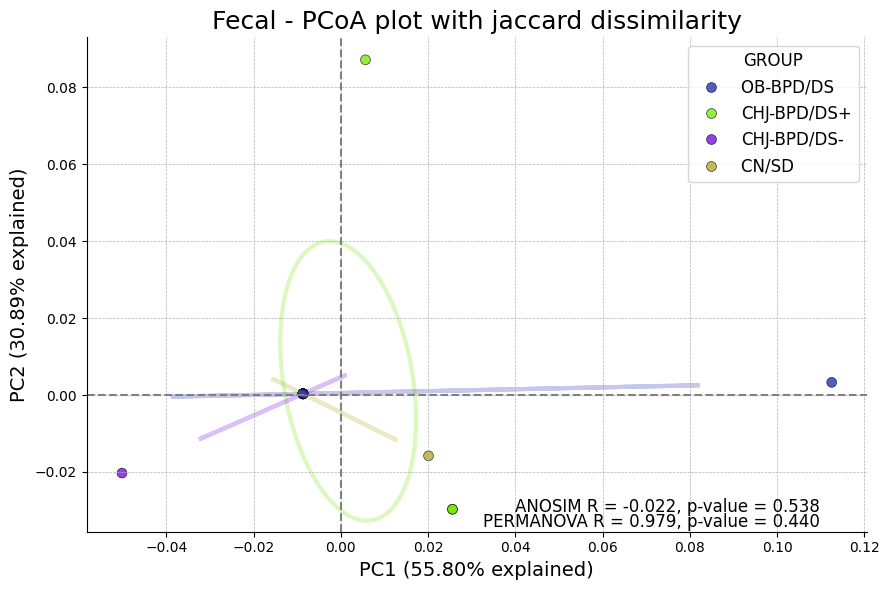

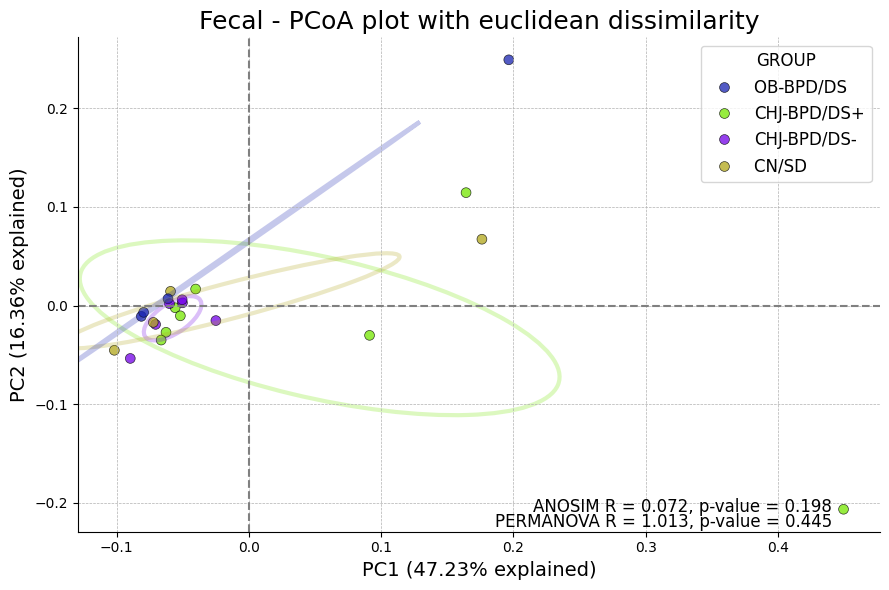

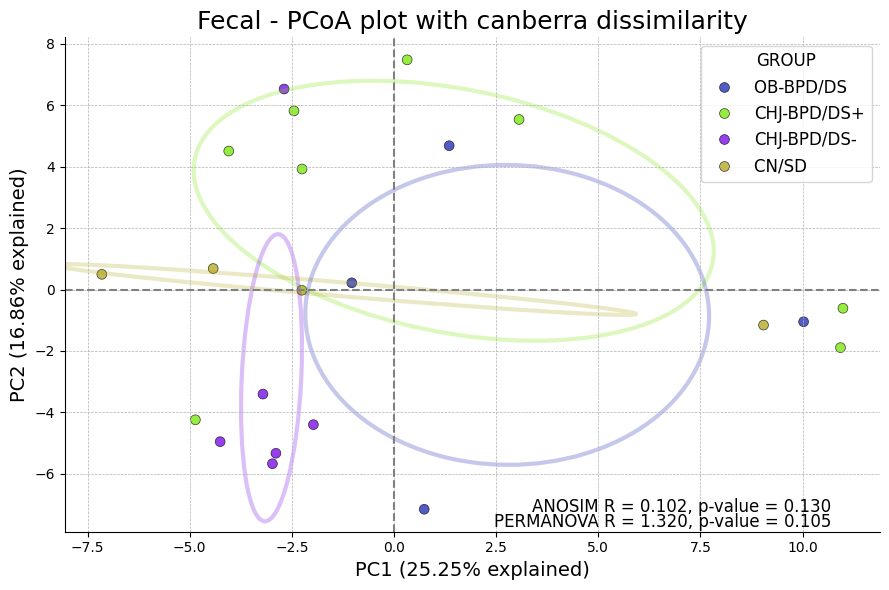

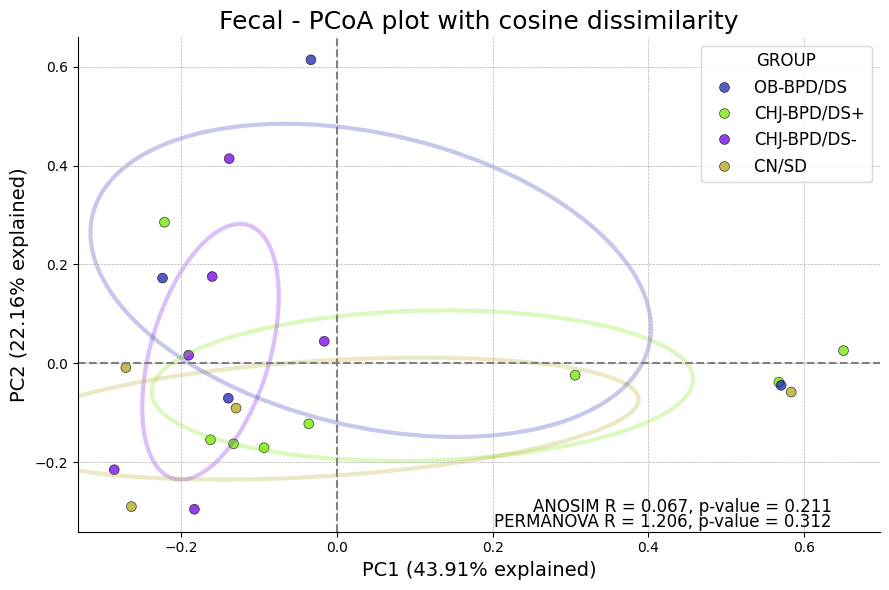

In [6]:
results_dict = msa.analyze_all_subgroups(df_filtered_family, SUPGROUP_LIST, group_list=GROUP_LIST)